In [303]:
from collections import Counter
from collections import defaultdict
import csv
from glob import glob
import json
import os.path as osp
from pprint import pprint

import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.spatial import ConvexHull

pd.set_option('display.max_row', 40)
pd.set_option('display.max_columns', 60)

try:
    sess.close()
except NameError:
    pass
sess = tf.InteractiveSession()

In [325]:
EXP_PREFIXES = [
#     # all parameters free
    "/home/rjulian/code/garage/data/local/ppo-point-embed/ppo_point_embed_2018_07_13_11_01_54_*",
    "/home/rjulian/code/garage/data/local/ppo-point-embed/ppo_point_embed_2018_07_16_13_34_30_*",
#     # embedding entropy pinned
#     "/home/rjulian/code/garage/data/local/ppo-point-embed-e-pinned",
#     # embedding entropy free with negative inf_ce
#     "/home/rjulian/code/garage/data/local/ppo-point-embed-e-free",
#     "/home/rjulian/code/garage/data/local/ppo-point-embed-inf-sweep",
]
EXP_LEN = 500

In [327]:
# Find and load experiments
experiments = {}
exp_names = []
exp_data = []

missing = []
count_pec = Counter()
count_eec = Counter()
count_icc = Counter()
count_iw = Counter()

# Load variant files and CSVs
for p in EXP_PREFIXES:
    for e in glob(p + "/**/variant.json", recursive=True):
        with open(e) as f:
            v = json.load(f)
            v_path = osp.dirname(e)

            # Add path data
            v["path"] = v_path

            ###### Get CSV data
            try:
                df = pd.read_csv(osp.join(v_path, "progress.csv"))
            except:
                missing.append(v_path)
                continue

            # Add entropy coeffs
            count_pec[v["policy_ent_coeff"]] += 1 
            coeff = np.full_like(df["Iteration"], v["policy_ent_coeff"], dtype=np.float64)
            df = df.assign(policy_ent_coeff=coeff)

            count_eec[v["embedding_ent_coeff"]] += 1
            coeff = np.full_like(df["Iteration"], v["embedding_ent_coeff"], dtype=np.float64)
            df = df.assign(embedding_ent_coeff=coeff)

            count_icc[v["inference_ce_coeff"]] += 1
            coeff = np.full_like(df["Iteration"], v["inference_ce_coeff"], dtype=np.float64)
            df = df.assign(inference_ce_coeff=coeff)
            
            count_iw[v["inference_window"]] += 1
            iw = np.full_like(df["Iteration"], v["inference_window"], dtype=np.float64)
            df = df.assign(inference_window=iw)

            v["csv"] = df
            
#             ##### Get TF data
#             tf_file = glob(v_path + "/events.out.tfevents*")[0]
#             print(tf_file)
#             itr = None
#             embedding_efficiency = []
#             for s in tf.train.summary_iterator(tf_file):
#                 for val in s.summary.value:
#                     if val.tag == "Iteration":
#                         itr = int(val.simple_value)
#                     if val.tag == "Embedding/i_0":
#                         print(val)

            ##### Add to experiment records
            experiments[v_path] = v
            exp_names.append(v["exp_name"])
            exp_data.append(df)

exp_data = pd.concat(exp_data, keys=exp_names, sort=True)
print("Loaded {} experiments...".format(len(experiments)))

Loaded 605 experiments...


In [328]:
print("policy_ent_coeff: {}".format(count_pec))
print("embedding_ent_coeff: {}".format(count_eec))
print("inference_ce_coeff: {}".format(count_icc))

policy_ent_coeff: Counter({0.001: 83, 1e-07: 81, 1e-05: 81, 0.0001: 81, 1e-06: 81, 0.1: 50, 0.01: 50, 1: 49, 2: 49})
embedding_ent_coeff: Counter({1e-07: 69, 1e-05: 69, 0.0001: 69, 1e-06: 69, 0.001: 69, 0.1: 65, 1: 65, 2: 65, 0.01: 65})
inference_ce_coeff: Counter({1e-06: 82, 1e-05: 81, 0.0001: 81, 0.01: 81, 0.001: 81, 1e-07: 64, 0.1: 45, 1: 45, 2: 45})


In [329]:
# Augment data with some aggregate task stats
# Completion Rate
min_cr = exp_data[["Tasks/CompletionRate/t=0", 
                   "Tasks/CompletionRate/t=1", 
                   "Tasks/CompletionRate/t=2", 
                   "Tasks/CompletionRate/t=3"]].min(axis=1)
exp_data = exp_data.assign(min_completion_rate=min_cr)
max_cr = exp_data[["Tasks/CompletionRate/t=0", 
                   "Tasks/CompletionRate/t=1", 
                   "Tasks/CompletionRate/t=2", 
                   "Tasks/CompletionRate/t=3"]].max(axis=1)
exp_data = exp_data.assign(max_completion_rate=max_cr)
med_cr = exp_data[["Tasks/CompletionRate/t=0", 
                   "Tasks/CompletionRate/t=1", 
                   "Tasks/CompletionRate/t=2", 
                   "Tasks/CompletionRate/t=3"]].median(axis=1)
exp_data = exp_data.assign(median_completion_rate=med_cr)
mean_cr = exp_data[["Tasks/CompletionRate/t=0", 
                    "Tasks/CompletionRate/t=1", 
                    "Tasks/CompletionRate/t=2", 
                    "Tasks/CompletionRate/t=3"]].mean(axis=1)
exp_data = exp_data.assign(mean_completion_rate=mean_cr)

# EpisodeLength
mean_el = exp_data[["Tasks/EpisodeLength/t=0", 
                    "Tasks/EpisodeLength/t=1", 
                    "Tasks/EpisodeLength/t=2", 
                    "Tasks/EpisodeLength/t=3"]].mean(axis=1)
exp_data = exp_data.assign(mean_episode_length=mean_el)

# par = 29
# score0 = (exp_data["Tasks/EpisodeLength/t=0"] - par)
# score1 = (exp_data["Tasks/EpisodeLength/t=1"] - par)
# score2 = (exp_data["Tasks/EpisodeLength/t=2"] - par)
# score3 = (exp_data["Tasks/EpisodeLength/t=3"] - par)

# score0 = (exp_data["embedding_ent_coeff"] * exp_data["Embedding/Entropy"]) \
#        + (exp_data["policy_ent_coeff"] * exp_data["Policy/Entropy"]) \
#        - (exp_data["inference_ce_coeff"] * exp_data["Inference/CrossEntropy"])
# score1 = (exp_data["embedding_ent_coeff"] * exp_data["Embedding/Entropy"]) \
#        + (exp_data["policy_ent_coeff"] * exp_data["Policy/Entropy"]) \
#        - (exp_data["inference_ce_coeff"] * exp_data["Inference/CrossEntropy"])
# score2 = (exp_data["embedding_ent_coeff"] * exp_data["Embedding/Entropy"]) \
#        + (exp_data["policy_ent_coeff"] * exp_data["Policy/Entropy"]) \
#        - (exp_data["inference_ce_coeff"] * exp_data["Inference/CrossEntropy"])
# score3 = (exp_data["embedding_ent_coeff"] * exp_data["Embedding/Entropy"]) \
#        + (exp_data["policy_ent_coeff"] * exp_data["Policy/Entropy"]) \
#        - (exp_data["inference_ce_coeff"] * exp_data["Inference/CrossEntropy"])

score0 = (1. * exp_data["Embedding/Entropy"]) \
       + (1. * exp_data["Policy/Entropy"]) \
       - (1. * exp_data["Inference/CrossEntropy"])
score1 = (1. * exp_data["Embedding/Entropy"]) \
       + (1. * exp_data["Policy/Entropy"]) \
       - (1. * exp_data["Inference/CrossEntropy"])
score2 = (1. * exp_data["Embedding/Entropy"]) \
       + (1. * exp_data["Policy/Entropy"]) \
       - (1. * exp_data["Inference/CrossEntropy"])
score3 = (1. * exp_data["Embedding/Entropy"]) \
       + (1. * exp_data["Policy/Entropy"]) \
       - (1. * exp_data["Inference/CrossEntropy"])

# score0 = exp_data["Tasks/CompletionRate/t=0"] / exp_data["AverageDiscountedReturn"]
# score1 = exp_data["Tasks/CompletionRate/t=1"] / exp_data["AverageDiscountedReturn"]
# score2 = exp_data["Tasks/CompletionRate/t=2"] / exp_data["AverageDiscountedReturn"]
# score3 = exp_data["Tasks/CompletionRate/t=3"] / exp_data["AverageDiscountedReturn"]

# score0 = exp_data[["Tasks/EpisodeLength/t=0", "Tasks/CompletionRate/t=0"]].prod(axis=1)
# score1 = exp_data[["Tasks/EpisodeLength/t=1", "Tasks/CompletionRate/t=1"]].prod(axis=1)
# score2 = exp_data[["Tasks/EpisodeLength/t=2", "Tasks/CompletionRate/t=2"]].prod(axis=1)
# score3 = exp_data[["Tasks/EpisodeLength/t=3", "Tasks/CompletionRate/t=3"]].prod(axis=1)

# score0 = exp_data[["Inference/RMSE", "AverageDiscountedReturn"]].prod(axis=1)
# score1 = exp_data[["Inference/RMSE", "AverageDiscountedReturn"]].prod(axis=1)
# score2 = exp_data[["Inference/RMSE", "AverageDiscountedReturn"]].prod(axis=1)
# score3 = exp_data[["Inference/RMSE", "AverageDiscountedReturn"]].prod(axis=1)
exp_data = exp_data.assign(completion_score_0=score0, 
                           completion_score_1=score1,
                           completion_score_2=score2,
                           completion_score_3=score3)
mean_cs = exp_data[["completion_score_0", 
                    "completion_score_1", 
                    "completion_score_2", 
                    "completion_score_3"]].mean(axis=1)
exp_data = exp_data.assign(mean_completion_score=mean_cs)
median_cs = exp_data[["completion_score_0", 
                      "completion_score_1", 
                      "completion_score_2", 
                      "completion_score_3"]].mean(axis=1)
exp_data = exp_data.assign(median_completion_score=median_cs)
min_cs = exp_data[["completion_score_0", 
                   "completion_score_1", 
                   "completion_score_2", 
                   "completion_score_3"]].min(axis=1)
exp_data = exp_data.assign(min_completion_score=min_cs)

In [428]:
# Summarize completion rates after i=400
after_train = exp_data.loc[exp_data["Iteration"] > 300].groupby(level=0).median()
filtered = after_train.loc[
    # (after_train["Embedding/Entropy"] > 0) & \
#     (after_train["embedding_ent_coeff"] == 1e-4) & \
#      (after_train["policy_ent_coeff"] == 1e-1) & \
#    (after_train["Embedding/KL"] < 100.) & \
#      (after_train["inference_ce_coeff"] > 0) & \
     (after_train["min_completion_rate"] > 0.95)& \
     (after_train["Baseline/ExplainedVariance"] > 0)
].sort_values(by=["mean_completion_score"], ascending=False)
filtered.index

Index(['ppo_point_embed_2018_07_13_11_01_54_0123',
       'ppo_point_embed_2018_07_16_13_34_30_0243',
       'ppo_point_embed_2018_07_16_13_34_30_0207',
       'ppo_point_embed_2018_07_13_11_01_54_0203',
       'ppo_point_embed_2018_07_13_11_01_54_0121',
       'ppo_point_embed_2018_07_13_11_01_54_0204',
       'ppo_point_embed_2018_07_16_13_34_30_0063',
       'ppo_point_embed_2018_07_16_13_34_30_0062',
       'ppo_point_embed_2018_07_16_13_34_30_0001',
       'ppo_point_embed_2018_07_16_13_34_30_0170',
       'ppo_point_embed_2018_07_13_11_01_54_0362',
       'ppo_point_embed_2018_07_13_11_01_54_0285',
       'ppo_point_embed_2018_07_13_11_01_54_0282',
       'ppo_point_embed_2018_07_13_11_01_54_0280',
       'ppo_point_embed_2018_07_13_11_01_54_0199',
       'ppo_point_embed_2018_07_16_13_34_30_0026',
       'ppo_point_embed_2018_07_16_13_34_30_0134',
       'ppo_point_embed_2018_07_16_13_34_30_0242',
       'ppo_point_embed_2018_07_16_13_34_30_0016',
       'ppo_point_embed_2018_07

In [429]:
# Filter exp_data for complete/non-degenerate coeffs
# plot_data = exp_data.loc[
#     True & \
# #     (exp_data["policy_ent_coeff"] == 1e-2) & \
#      (exp_data["embedding_ent_coeff"] < 1e-2) & \
#      (exp_data["inference_ce_coeff"] > 0) & \
#      (exp_data["min_completion_rate"] > 0.9) & \
# #     (exp_data["inference_window"] == 4.0) & \
# #     (exp_data["inference_ce_coeff"] <= 1e-1) & \
# #    (exp_data["Embedding/Entropy"] > 3) & \
# #     (exp_data["Embedding/Entropy"] < 10) & \
#     True
# ]
plot_data = exp_data.loc[filtered.index]

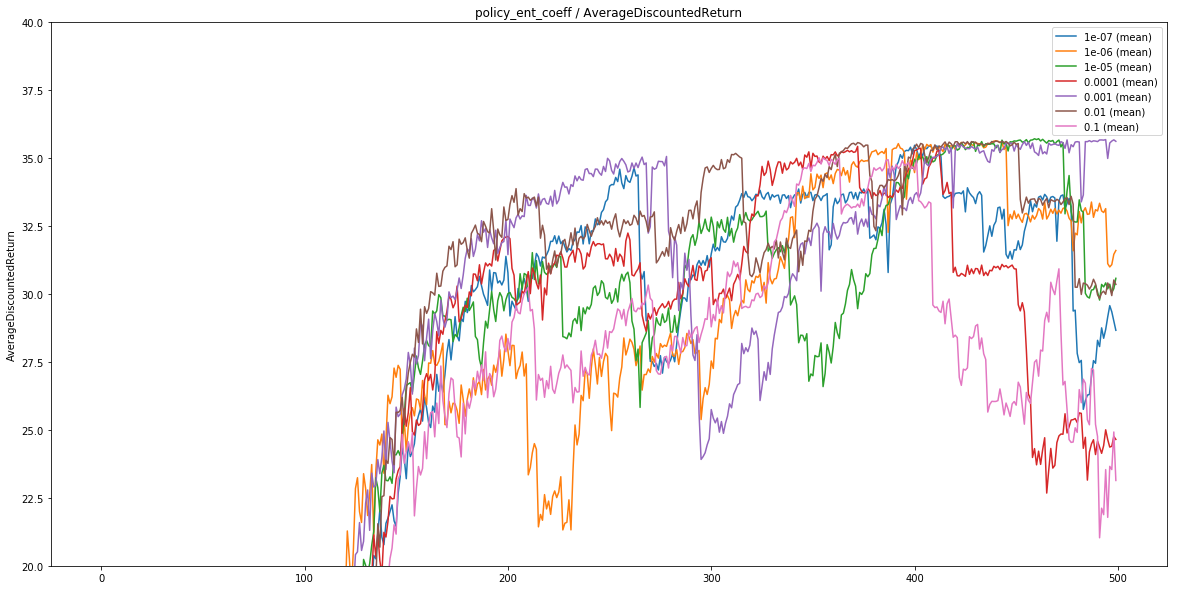

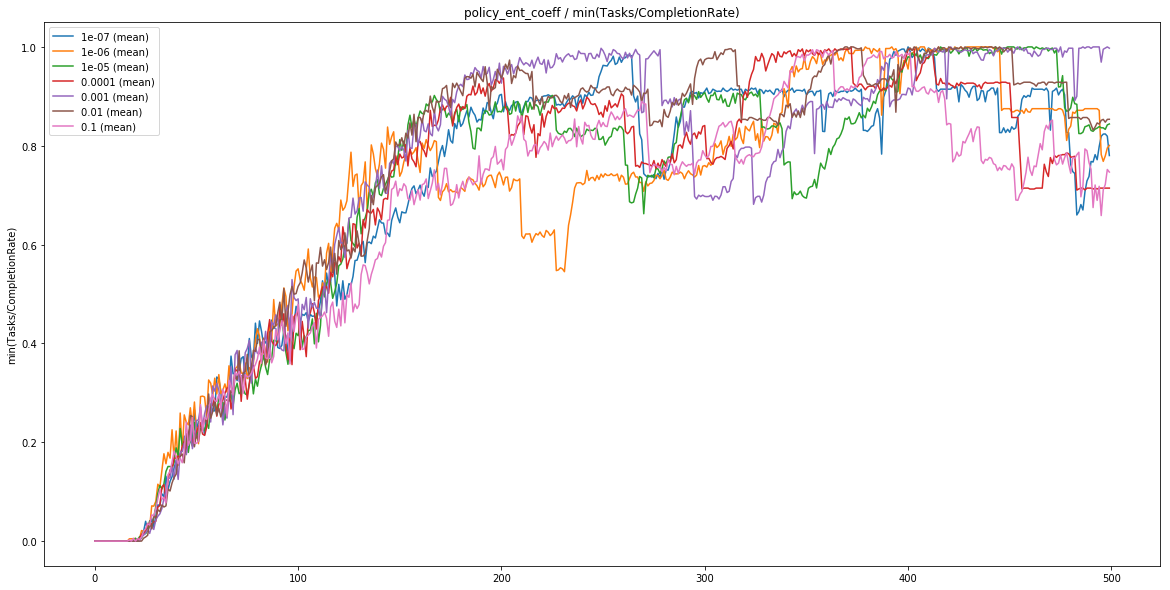

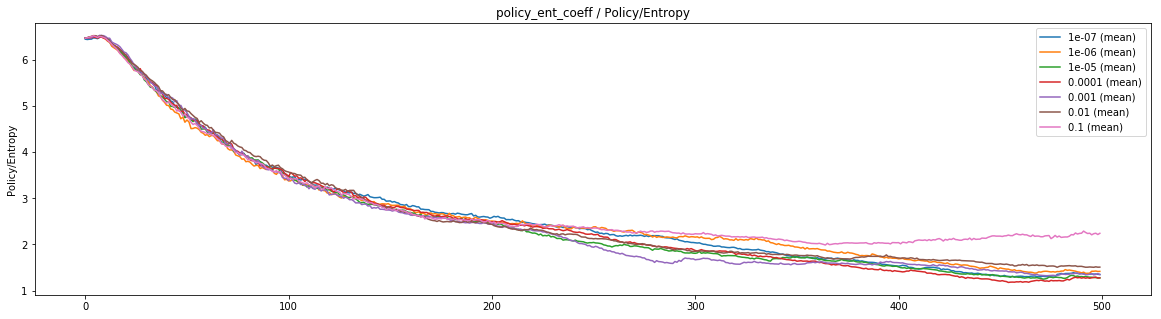

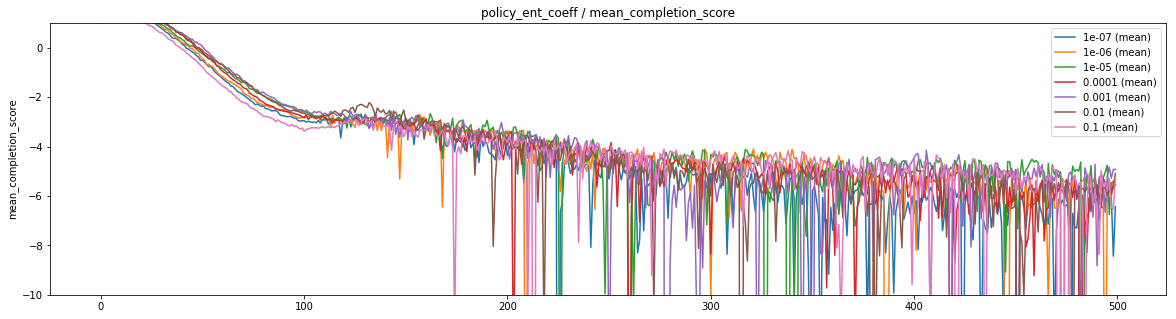

In [430]:
# Plot by policy_ent_coeff
pec_data = plot_data.groupby("policy_ent_coeff")
fig, ax = plt.subplots(figsize=(20,10))
fig2,ax2 = plt.subplots(figsize=(20,10))
fig3,ax3 = plt.subplots(figsize=(20,5))
fig4,ax4 = plt.subplots(figsize=(20,5))
for pec in sorted(pec_data.groups.keys()):
    maxs = pec_data.get_group(pec).groupby("Iteration").max()
    mins = pec_data.get_group(pec).groupby("Iteration").min()
    means = pec_data.get_group(pec).groupby("Iteration").mean()
    medians = pec_data.get_group(pec).groupby("Iteration").median()
    
    # AverageDiscountedReturn
    ax.plot(means.index, means["AverageDiscountedReturn"], label="{} (mean)".format(str(pec)))
    ax.set_title("policy_ent_coeff / AverageDiscountedReturn")
    ax.set_ylabel("AverageDiscountedReturn")
    ax.set_ylim([20, 40])
    ax.legend()
    
    # min(CompletionRate)
    ax2.plot(means.index, means["min_completion_rate"], label="{} (mean)".format(str(pec)))
    ax2.set_title("policy_ent_coeff / min(Tasks/CompletionRate)")
    ax2.set_ylabel("min(Tasks/CompletionRate)")
    ax2.legend()
    
    # Policy/Entropy
    ax3.plot(means.index, means["Policy/Entropy"], label="{} (mean)".format(str(pec)))
    ax3.set_title("policy_ent_coeff / Policy/Entropy")
    ax3.set_ylabel("Policy/Entropy")
    ax3.legend()
    
    # mean_completion_score
    ax4.plot(means.index, means["median_completion_score"], label="{} (mean)".format(str(pec)))
    ax4.set_title("policy_ent_coeff / mean_completion_score")
    ax4.set_ylabel("mean_completion_score")
    ax4.set_ylim([-10, 1])
    ax4.legend()

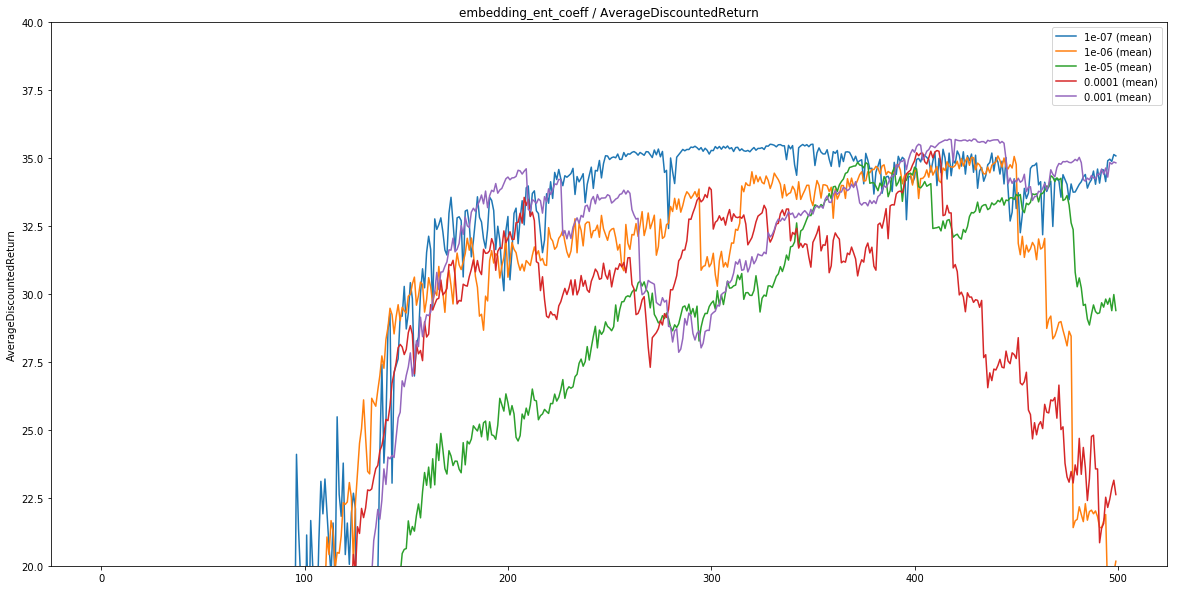

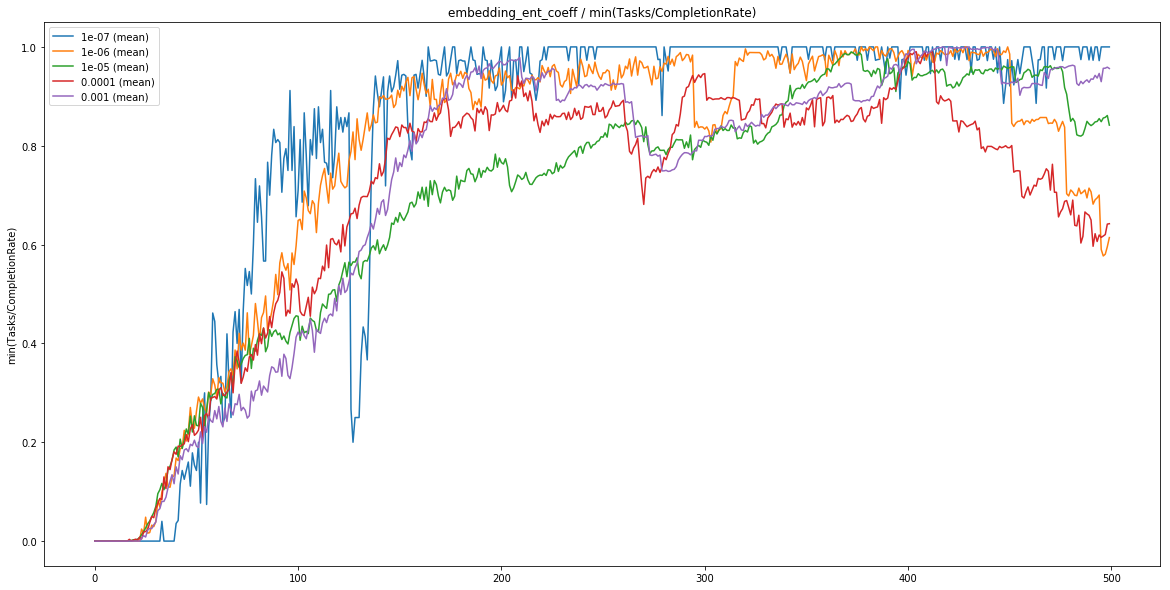

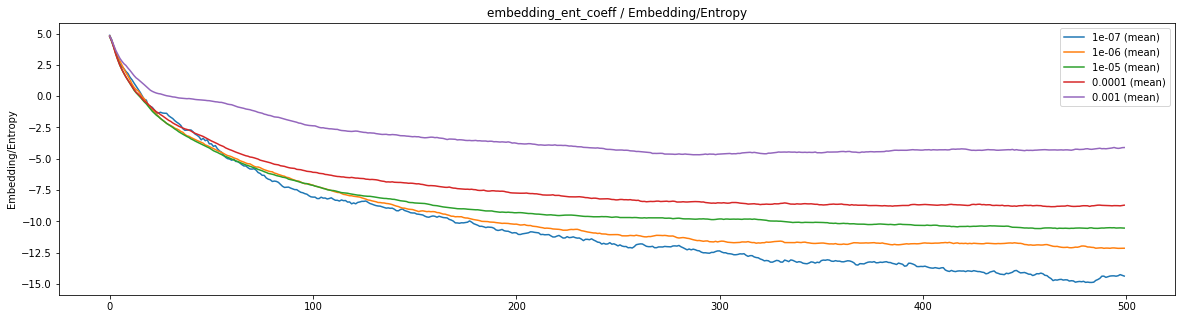

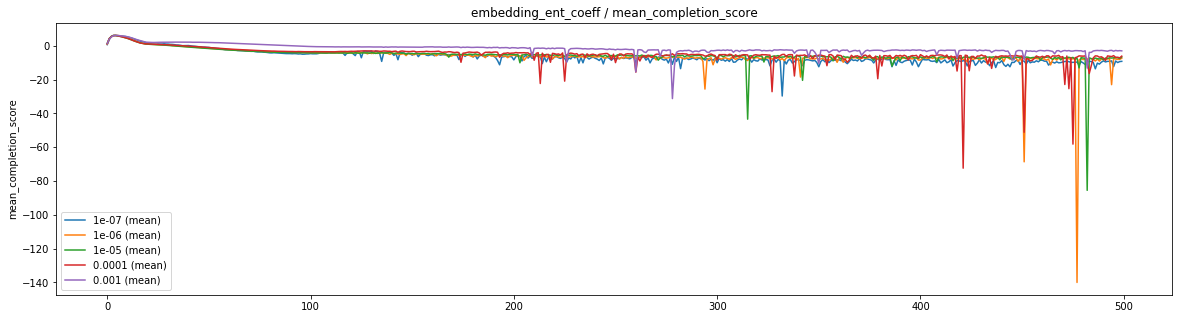

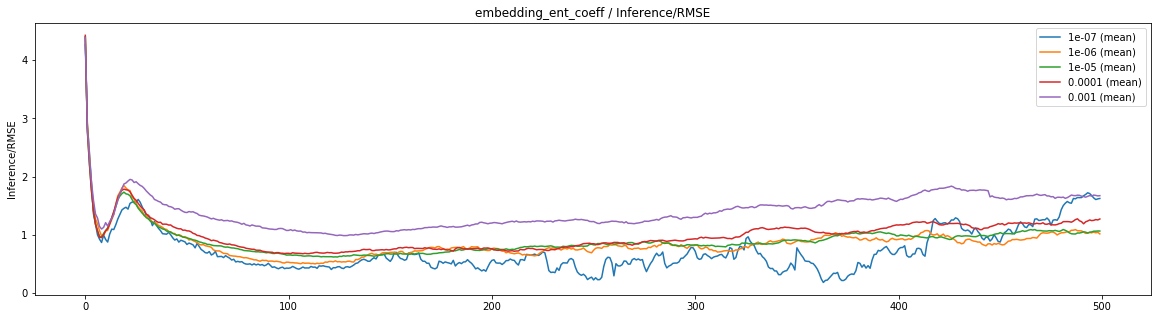

In [431]:
# Plot by embedding_ent_coeff
fig, ax = plt.subplots(figsize=(20,10))
fig2, ax2 = plt.subplots(figsize=(20,10))
fig3, ax3 = plt.subplots(figsize=(20,5))
fig4, ax4 = plt.subplots(figsize=(20,5))
fig5, ax5 = plt.subplots(figsize=(20,5))
eec_data = plot_data.groupby("embedding_ent_coeff")
for eec in sorted(eec_data.groups.keys()):
    means = eec_data.get_group(eec).groupby("Iteration").mean()
    maxs = eec_data.get_group(eec).groupby("Iteration").max()
    mins = eec_data.get_group(eec).groupby("Iteration").min()
    medians = eec_data.get_group(eec).groupby("Iteration").median()
    
    # AverageDiscountedReturn
    ax.plot(means.index, means["AverageDiscountedReturn"], label="{} (mean)".format(str(eec)))
    ax.set_title("embedding_ent_coeff / AverageDiscountedReturn")
    ax.set_ylabel("AverageDiscountedReturn")
    ax.set_ylim([20, 40])
    ax.legend()
    
    # mean(CompletionRate)
    ax2.plot(means.index, means["min_completion_rate"], label="{} (mean)".format(str(eec)))
    ax2.set_title("embedding_ent_coeff / min(Tasks/CompletionRate)")
    ax2.set_ylabel("min(Tasks/CompletionRate)")
    ax2.legend()
    
    # Embedding/Entropy
    ax3.plot(means.index, means["Embedding/Entropy"], label="{} (mean)".format(str(eec)))
    ax3.set_title("embedding_ent_coeff / Embedding/Entropy")
    ax3.set_ylabel("Embedding/Entropy")
    ax3.legend()
    
    # mean_completion_score
    ax4.plot(means.index, means["mean_completion_score"], label="{} (mean)".format(str(eec)))
    ax4.set_title("embedding_ent_coeff / mean_completion_score")
    ax4.set_ylabel("mean_completion_score")
    ax4.legend()
    
    # Inference/RMSE
    ax5.plot(means.index, means["Inference/RMSE"], label="{} (mean)".format(str(eec)))
    ax5.set_title("embedding_ent_coeff / Inference/RMSE")
    ax5.set_ylabel("Inference/RMSE")
    ax5.legend()

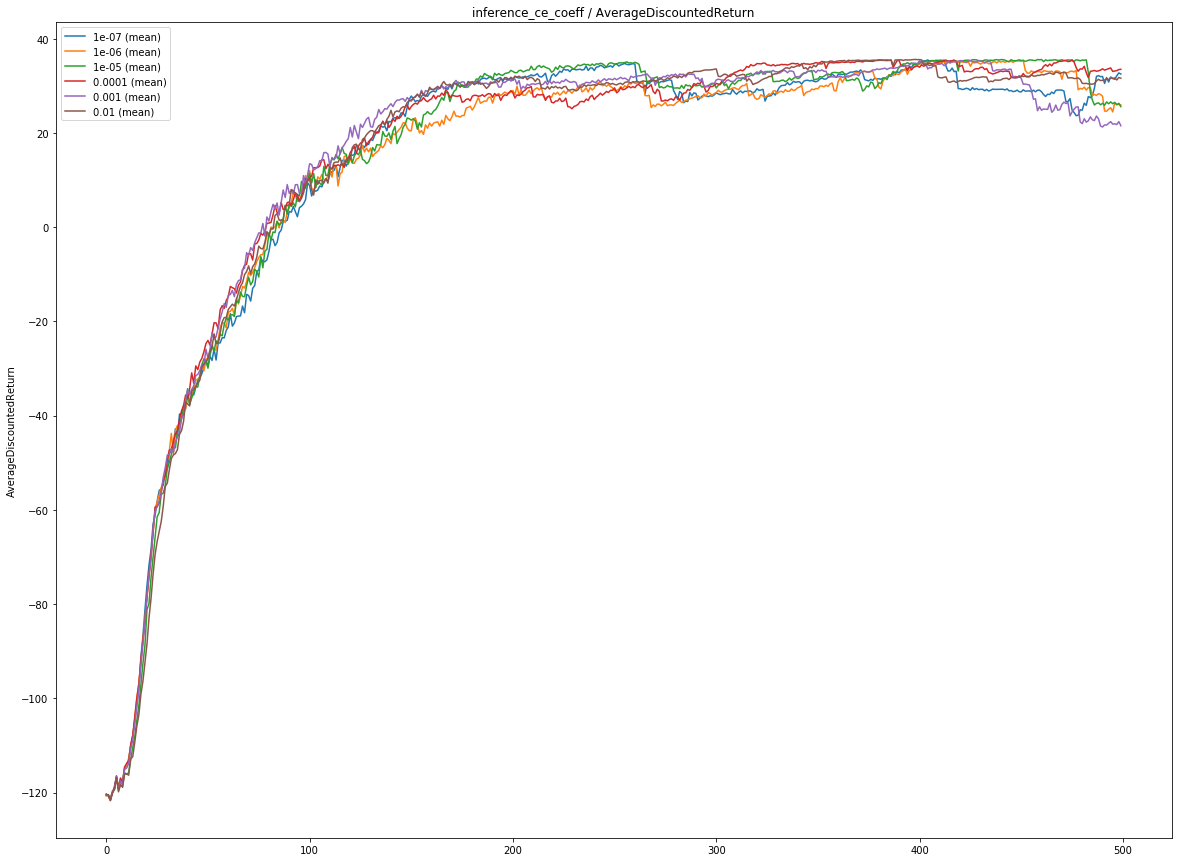

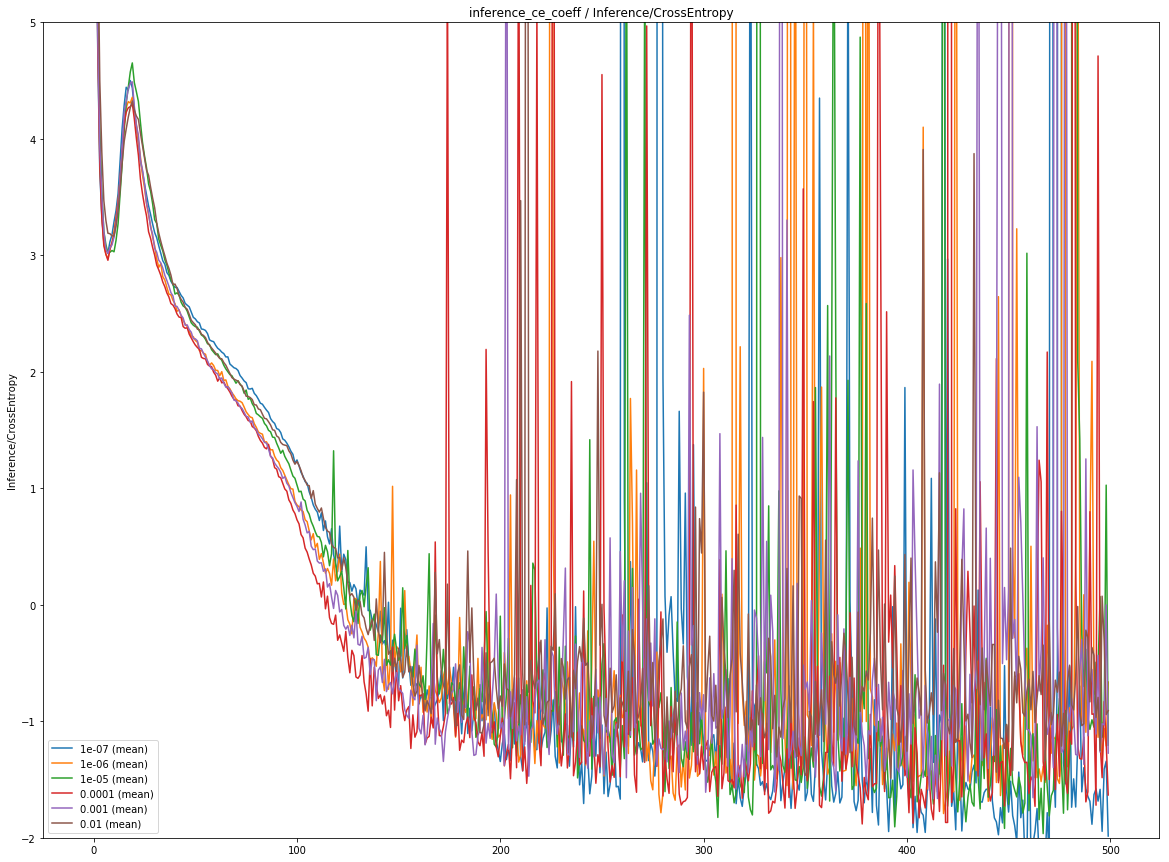

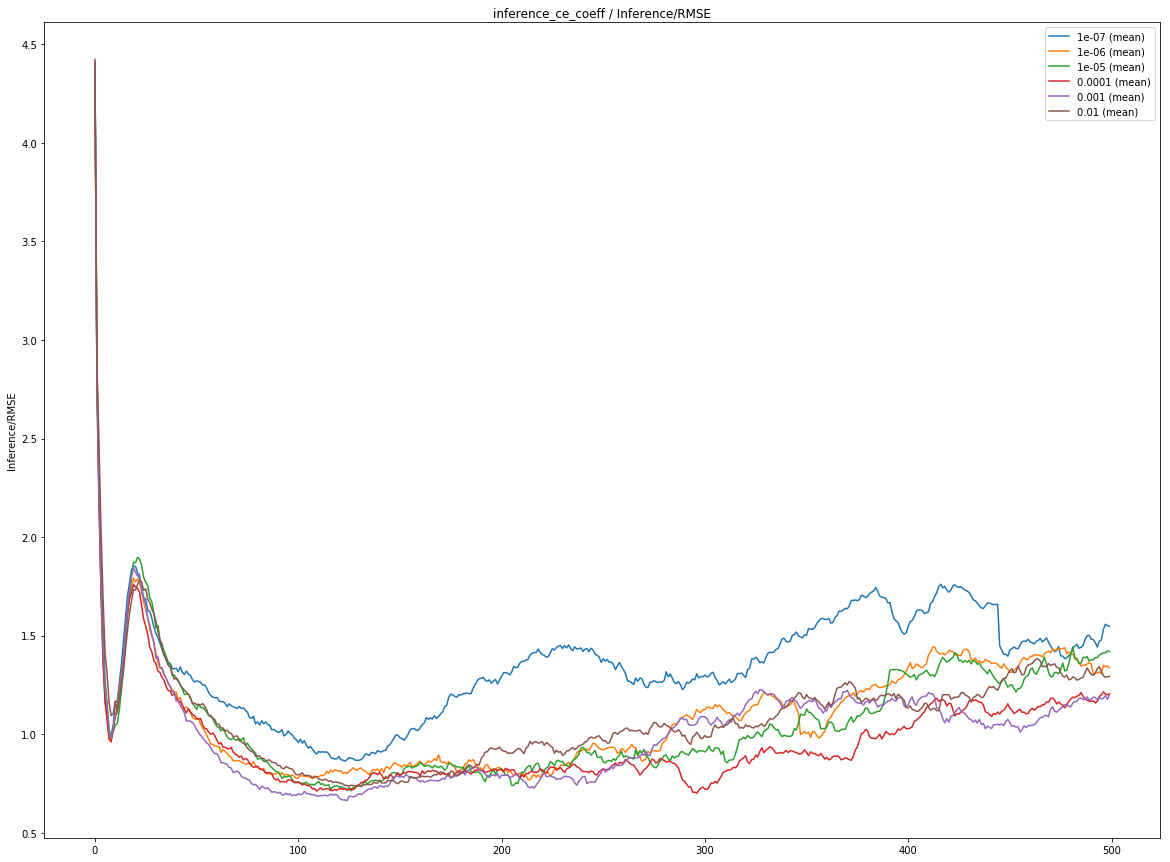

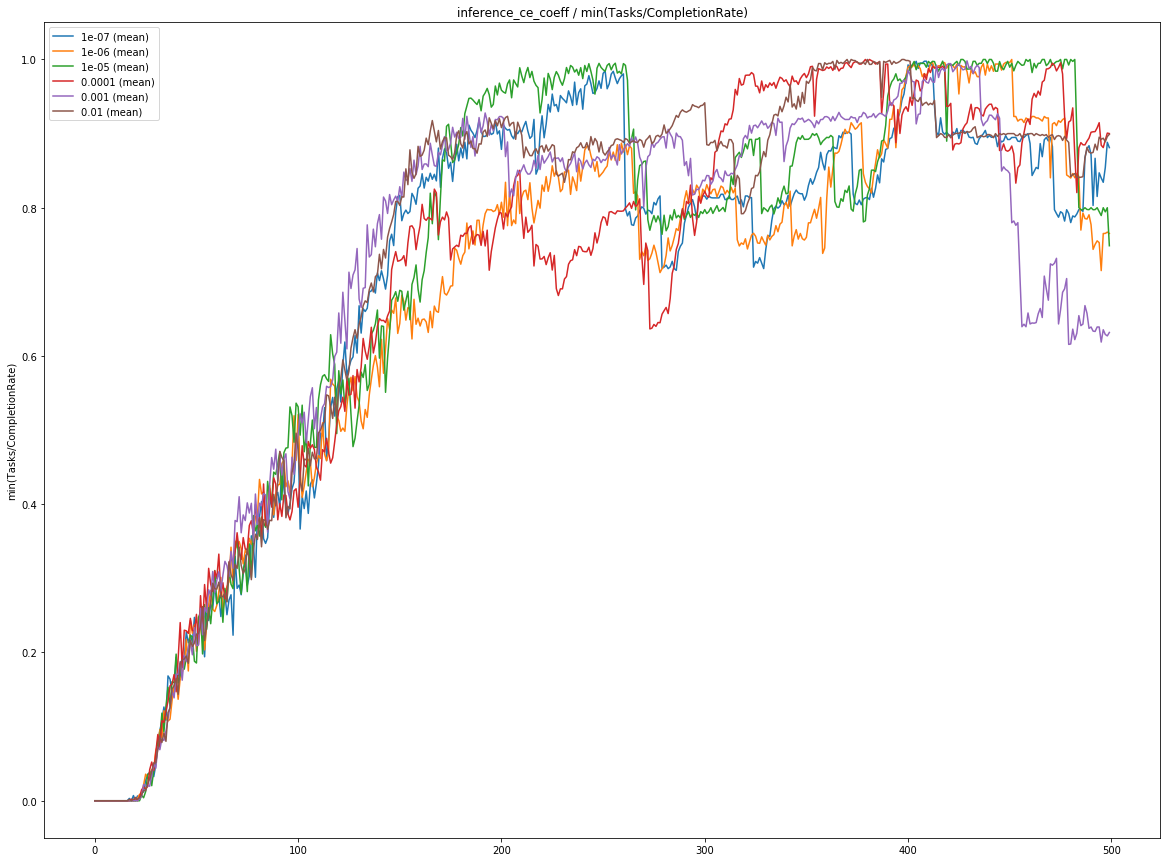

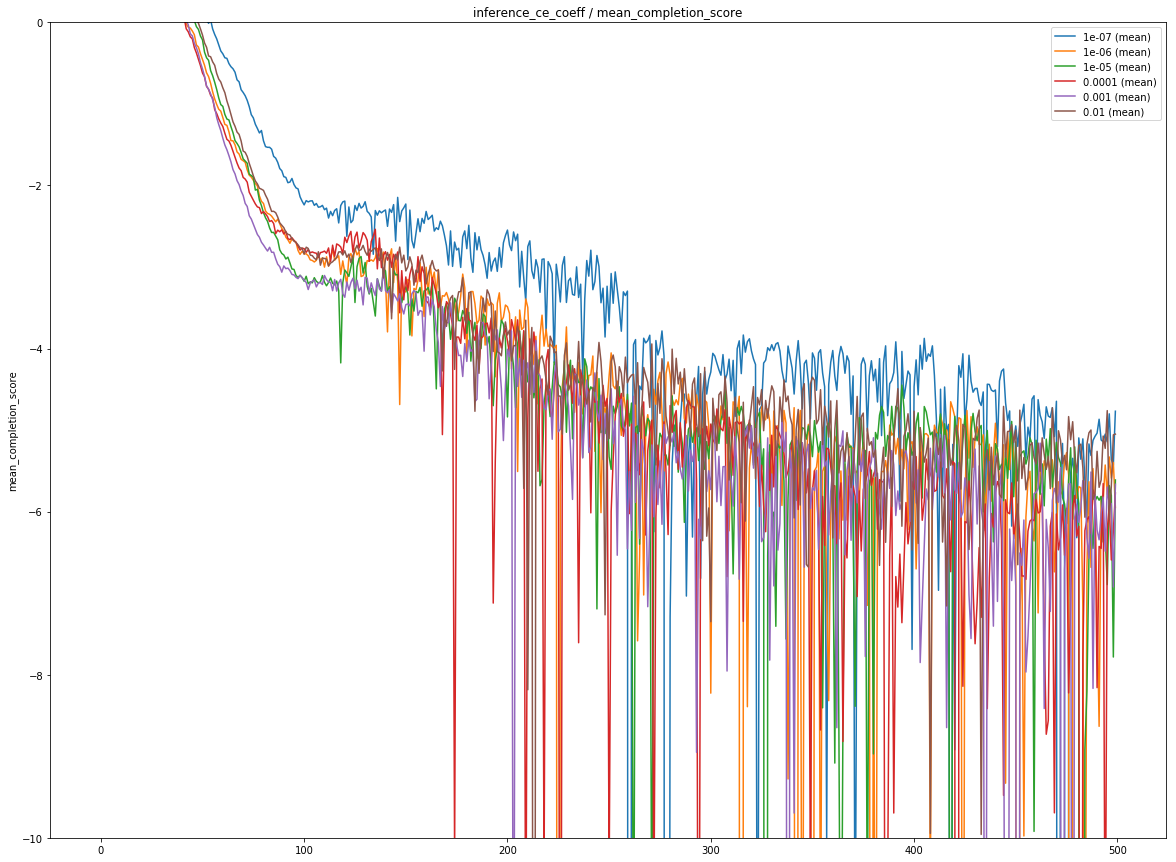

In [432]:
# Plot by inference_ce_coeff
fig, ax = plt.subplots(figsize=(20,15))
fig2, ax2 = plt.subplots(figsize=(20,15))
fig3, ax3 = plt.subplots(figsize=(20,15))
fig4, ax4 = plt.subplots(figsize=(20,15))
fig5, ax5 = plt.subplots(figsize=(20,15))
icc_data = plot_data.groupby("inference_ce_coeff")
for icc in sorted(icc_data.groups.keys()):
    means = icc_data.get_group(icc).groupby("Iteration").mean()
    maxs = icc_data.get_group(icc).groupby("Iteration").max()
    mins = icc_data.get_group(icc).groupby("Iteration").min()
    medians = icc_data.get_group(icc).groupby("Iteration").median()
    
#     if icc < 0:
#         color = 'r'
#     else:
#         color = 'b'
    color = None
    
    # AverageDiscountedReturn
    ax.plot(means.index, means["AverageDiscountedReturn"], label="{} (mean)".format(str(icc)), color=color)
    ax.set_title("inference_ce_coeff / AverageDiscountedReturn")
    ax.set_ylabel("AverageDiscountedReturn")
    ax.legend()
    
    # Inference/CrossEntropy
    ax2.plot(means.index, means["Inference/CrossEntropy"], label="{} (mean)".format(str(icc)), color=color)
    ax2.set_title("inference_ce_coeff / Inference/CrossEntropy")
    ax2.set_ylabel("Inference/CrossEntropy")
    ax2.set_ylim([-2, 5])
    ax2.legend()
    
    # Inference/RMSE
    ax3.plot(means.index, means["Inference/RMSE"], label="{} (mean)".format(str(icc)), color=color)
    ax3.set_title("inference_ce_coeff / Inference/RMSE")
    ax3.set_ylabel("Inference/RMSE")
    ax3.legend()
    
    # min(CompletionRate)
    ax4.plot(means.index, means["min_completion_rate"], label="{} (mean)".format(str(icc)), color=color)
    ax4.set_title("inference_ce_coeff / min(Tasks/CompletionRate)")
    ax4.set_ylabel("min(Tasks/CompletionRate)")
    ax4.legend()
    
    # mean_completion_score
    ax5.plot(means.index, means["mean_completion_score"], label="{} (mean)".format(str(icc)), color=color)
    ax5.set_title("inference_ce_coeff / mean_completion_score")
    ax5.set_ylabel("mean_completion_score")
    ax5.set_ylim([-10, 0])
    ax5.legend()

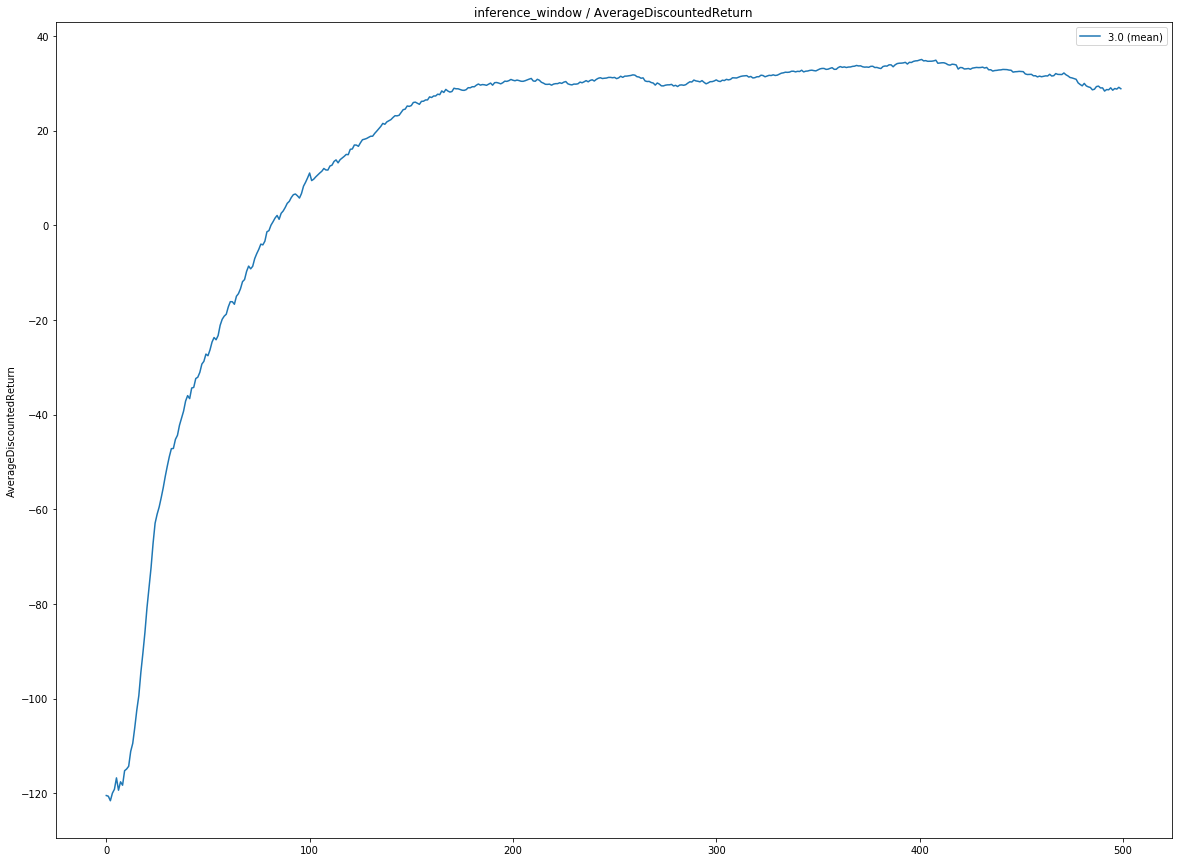

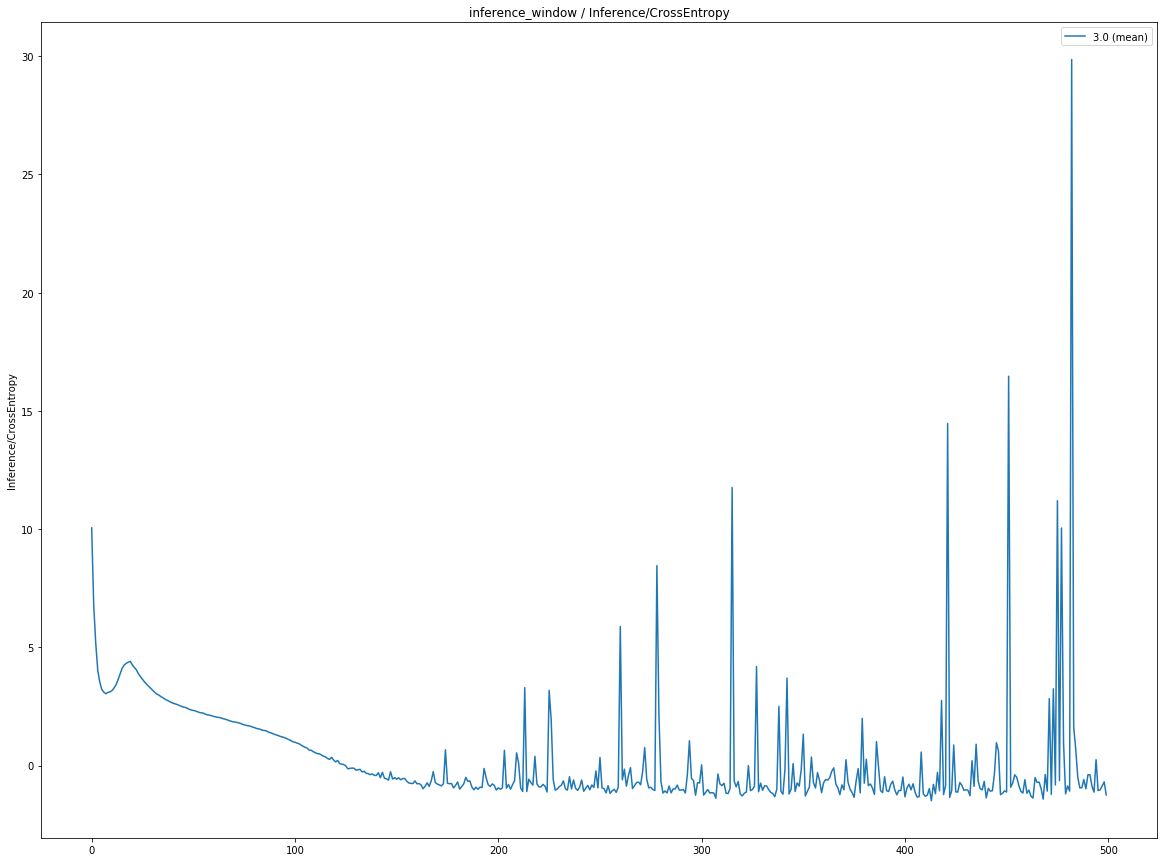

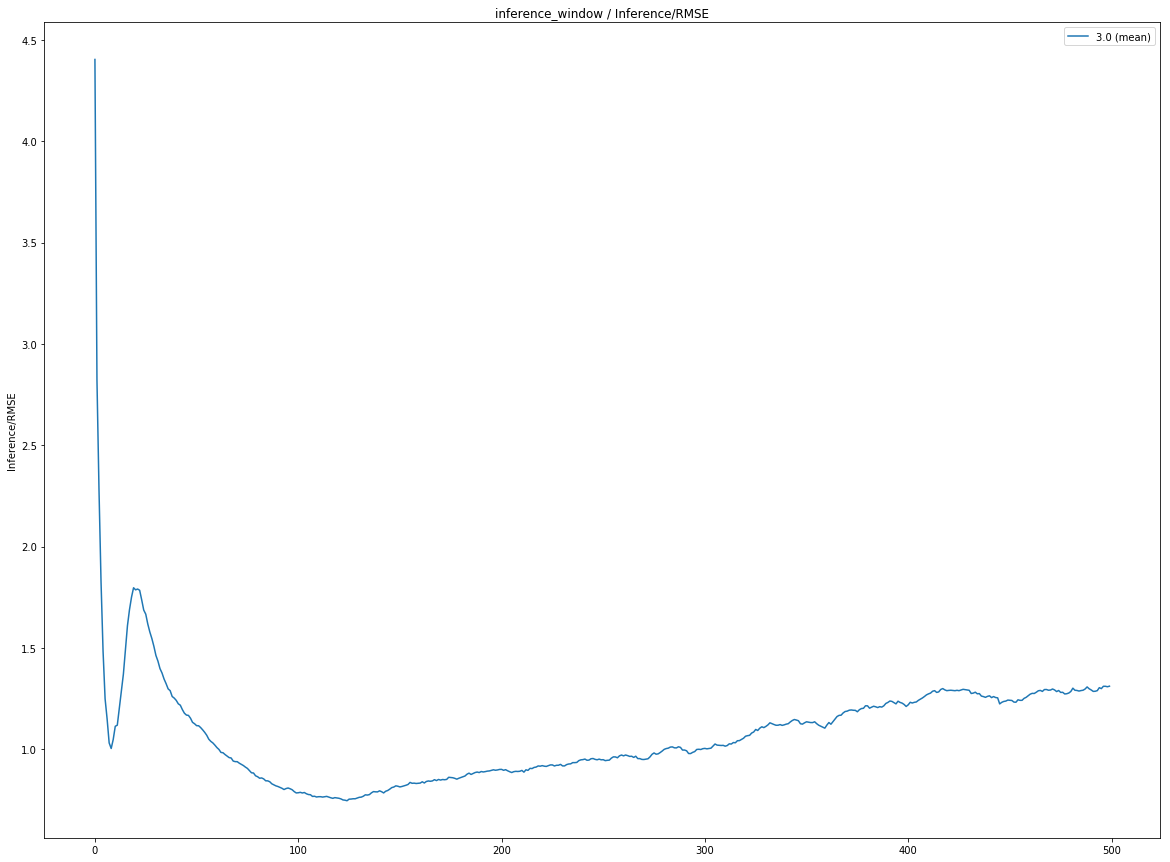

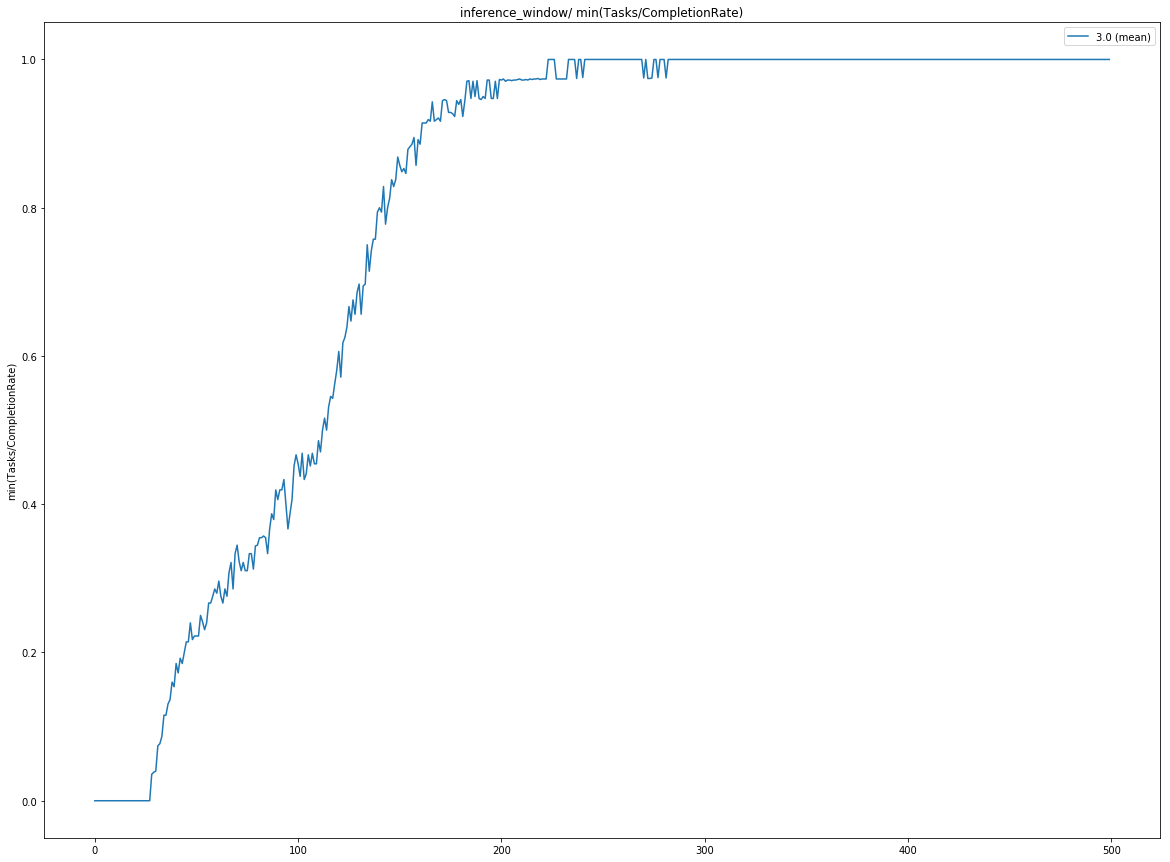

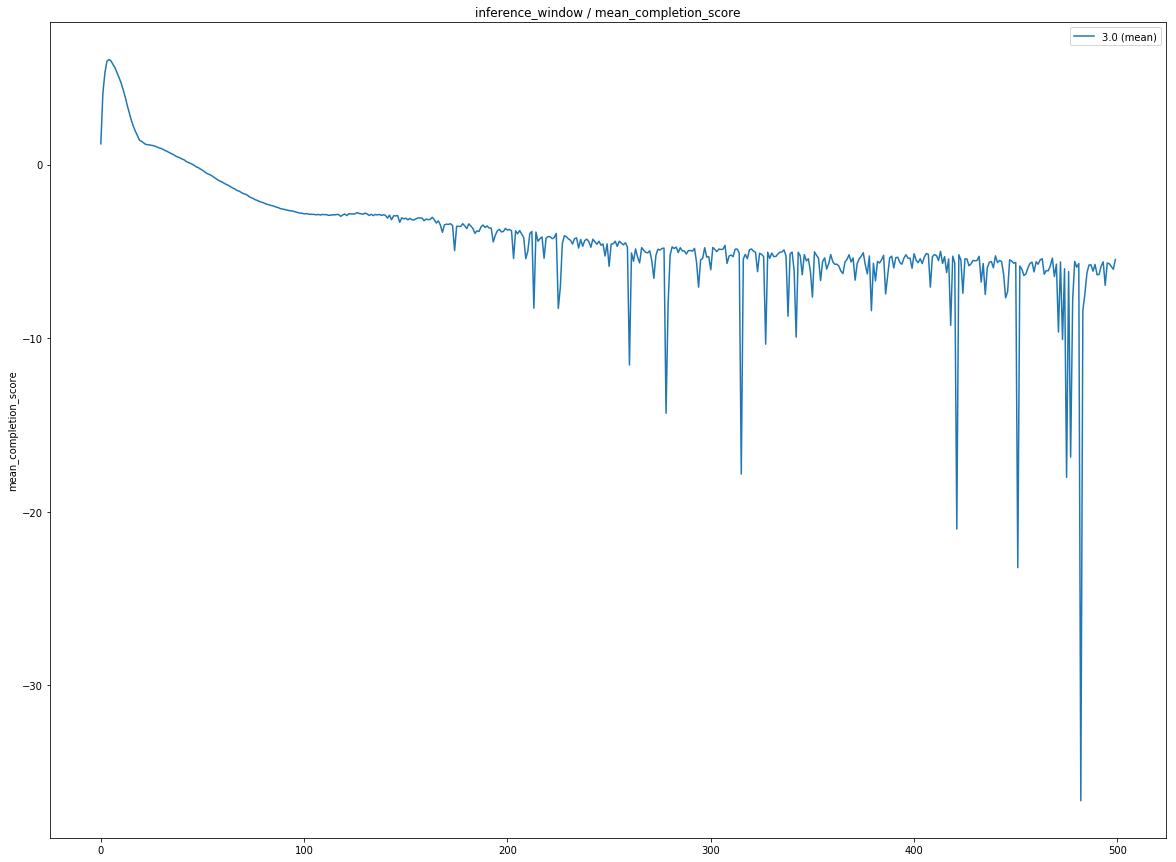

In [433]:
# Plot by inference_ce_coeff
fig, ax = plt.subplots(figsize=(20,15))
fig2, ax2 = plt.subplots(figsize=(20,15))
fig3, ax3 = plt.subplots(figsize=(20,15))
fig4, ax4 = plt.subplots(figsize=(20,15))
fig5, ax5 = plt.subplots(figsize=(20,15))
iw_data = plot_data.groupby("inference_window")
for iw in sorted(iw_data.groups.keys()):
    means = iw_data.get_group(iw).groupby("Iteration").mean()
    maxs = iw_data.get_group(iw).groupby("Iteration").max()
    mins = iw_data.get_group(iw).groupby("Iteration").min()
    medians = iw_data.get_group(iw).groupby("Iteration").median()
    
    # AverageDiscountedReturn
    ax.plot(means.index, means["AverageDiscountedReturn"], label="{} (mean)".format(str(iw)))
    ax.set_title("inference_window / AverageDiscountedReturn")
    ax.set_ylabel("AverageDiscountedReturn")
    ax.legend()
    
    # Inference/CrossEntropy
    ax2.plot(means.index, means["Inference/CrossEntropy"], label="{} (mean)".format(str(iw)))
    ax2.set_title("inference_window / Inference/CrossEntropy")
    ax2.set_ylabel("Inference/CrossEntropy")

    ax2.legend()
    
    # Inference/RMSE
    ax3.plot(means.index, means["Inference/RMSE"], label="{} (mean)".format(str(iw)))
    ax3.set_title("inference_window / Inference/RMSE")
    ax3.set_ylabel("Inference/RMSE")
    ax3.legend()
    
    # min(CompletionRate)
    ax4.plot(medians.index, medians["min_completion_rate"], label="{} (mean)".format(str(iw)))
    ax4.set_title("inference_window/ min(Tasks/CompletionRate)")
    ax4.set_ylabel("min(Tasks/CompletionRate)")
    ax4.legend()
    
    # mean_completion_score
    ax5.plot(means.index, means["mean_completion_score"], label="{} (mean)".format(str(iw)))
    ax5.set_title("inference_window / mean_completion_score")
    ax5.set_ylabel("mean_completion_score")
    ax5.legend()